In [216]:
import warnings
import datetime
import copy
import numpy as np
import pandas as pd
import pickle as pkl
from seaborn import plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from cgmtools import plotting
from cgmtools.utils import gluco_extract

import statsmodels.api as sm


from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import TimeSeriesSplit

%matplotlib inline

# 1. Preliminary steps
## 1.1 Load glucose data

In [30]:
# load data set from pickle file
dfs_full = pkl.load(open('../../data/dfs_py3.pkl', 'rb'))

## 1.1 Remove short acquisitions

In [31]:
# Keep only patients with more than 3.5 days of acquisition
thresh = datetime.timedelta(days=3.5)

# List of patients that satisfy inclusion criterion
ok_keys = []

for k in dfs_full.keys():
    df = dfs_full[k]
    time, gluco = gluco_extract(df)
    try:
        delta = time[-1] - time[0]
        if delta > thresh: ok_keys.append(k)
    except:
        pass
# Filter short time-series
dfs = {k: dfs_full[k] for k in ok_keys}

D'Agostino Francesca 2.csv


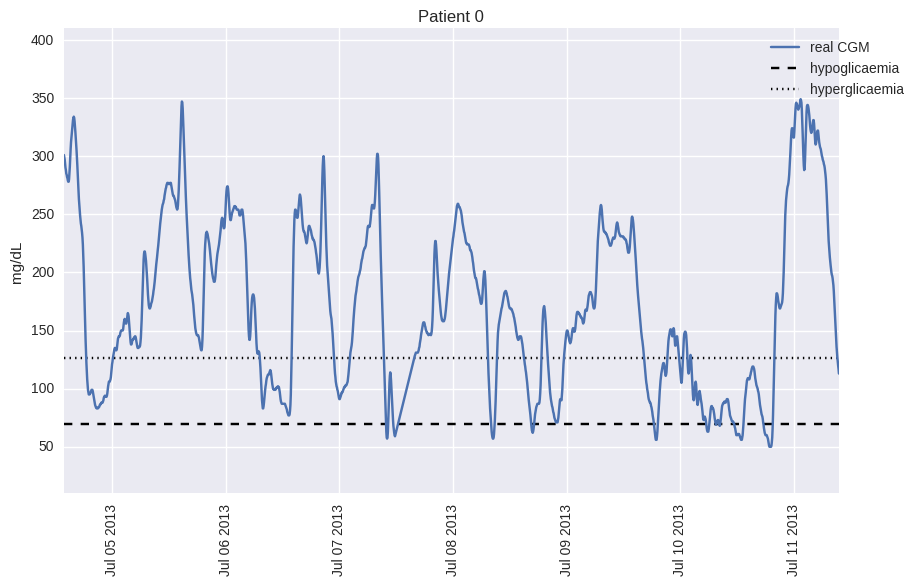

In [32]:
# Example: plot a single patient
k = 0
idx = list(dfs.keys())[k]
print(idx)

# Select the appropriate DF
df = dfs[idx]
   
_df = gluco_extract(df, return_df=True)
plotting.cgm(_df, title='Patient '+str(k))

# 2. Run predictions
## 2.1 Kalman

In [33]:
from pykalman import KalmanFilter
import scipy.io as sio

In [28]:
# ------------ Load .mat file ------------ #
data = sio.loadmat('cgm_sample2.mat')
P0 = data['P0'] # covariance matrix init
ts = data['ts'] # time axis
X0 = data['X0'] # state at time 0
ys = data['ys'] # CGM values
# ---------------------------------------- #

# ys = ys[:10,:]
# ts = ts[:10,:]

# ------------ Init handy values --------- #
Ns = len(ts) # number of samples
Pold = np.array(P0) # cov matrix init
Xold = np.array(X0) # state init
# y(t) = u(t) + v(t)
lamb2 = np.array([1, 0.01, 0.0001]) # values for q00 (variance of u(t))

F = np.array([[2, -1], [1, 0]]) # transition matrix
H = np.array([1, 0]) # measures matrix
Q = np.array([[lamb2[1], 0], [0, 0]])
R = 9
# ---------------------------------------- #

# ------------ Kalman Filtering ---------- #
# kf = KalmanFilter(transition_matrices=F,
#                   observation_matrices=H,
#                   transition_covariance=Q,
#                   observation_covariance=R,
#                   initial_state_mean=Xold.ravel(),
#                   initial_state_covariance=Pold)
kf = KalmanFilter(transition_matrices=None,
                  observation_matrices=H,
                  transition_covariance=None,
                  observation_covariance=R,
                  initial_state_mean=Xold.ravel(),
                  initial_state_covariance=Pold)
y = np.zeros(Ns) # filtered output
# print(kf.em(ys,em_vars=('transition_matrices','transition_covariance')).transition_matrices)
Xnew, Pnew = kf.em(ys,em_vars=('transition_matrices','transition_covariance')).filter(ys)

for t in np.arange(Ns):
    # Xnew, Pnew = kf.filter_update(filtered_state_mean=Xold.ravel(),
    #                               filtered_state_covariance=Pold,
    #                               observation=ys[t])
    # Pold = np.array(Pnew)
    # Xold = np.array(Xnew)
    y[t] = np.dot(Xnew[t,:],H)
    # y[t] = np.dot(Xnew,H)
# ---------------------------------------- #

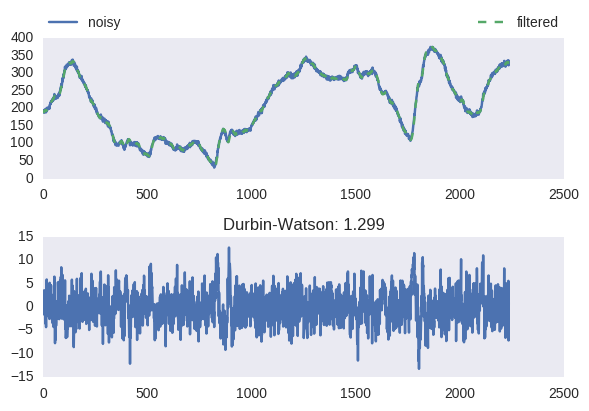

In [36]:
# ---------- Plot ------------------------ #
plt.subplot(211)
plt.plot(ts, ys, '-', label='noisy') # noisy measures
plt.plot(ts, y, '--', label='filtered') # filtered measures
plt.grid()
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)
plt.subplot(212)
residuals = ys.ravel()[0:Ns] - y.ravel()[0:Ns]
plt.plot(ts, residuals)
plt.title('Durbin-Watson: {:.3f}'.format(sm.stats.durbin_watson(residuals)));
plt.tight_layout()
plt.grid()

## Translate `pykalman` names into our convention

**Parameter Name** (Notation)
- initial_state_mean (`X0`)
- initial_state_covariance (`P0`)
- transition_matrices (`F`)
- transition_offsets (0?)
- transition_covariance (`Q`)
- observation_matrices (`X`)
- observation_offsets (0?)
- observation_covariance (`R`)

In [134]:
def CGMKalmanFilter(X0=None, P0=None, F=None, Q=None,
                    X=None, R=None, random_state=None, em_vars=None, **kwargs):
    """Kalman Filter wrapper that uses compact names notation.
    
       Unspecified KalmanFilter arguments are:
       - transition_offsets
       - observation_offsets
       - n_dim_state
       - n_dim_obs
       their access granted via **kwargs
    """
    return KalmanFilter(transition_matrices=F,
                        observation_matrices=X,
                        transition_covariance=Q,
                        observation_covariance=R,
                        initial_state_mean=X0,
                        initial_state_covariance=P0,
                        random_state=random_state,
                        em_vars=em_vars, **kwargs)


In [271]:
def forecast(kf=None, n_steps=1, X_old=None, P_old=None, H=None,
             y=None, return_first_kf=False):
    """Forecast n_steps-ahead using the input Kalman filter.
    
    Parameters
    -------------------
    kf : pykalman.standard.KalmanFilter, the (fitted) KF to use
         to perform forecast
    n_steps : number, the prediction horizon (default = 1)
    H : array of float, the acquisition model
    y : array of float, the observation until the last acquired sample
    return_first_kf : bool, return the KF used to perform
                      the first one-step-ahead prediction
    
    Returns
    -------------------
    y_pred : array of float, the `n_steps` predicted future values
    X_new : array of float, the one-step-updated state matrix 
    P_new : array of float, the one-step-updated state covariance matrix
    kf_out : pykalman.standard.KalmanFilter, the KF used to perform
             the first one-step-ahead prediction (if return_first_kf=True)
    """
    if n_steps <= 0:
        raise Exception('n_steps must be at least 1')
    
    # Init predictions
    y_pred = np.zeros(n_steps)
    
    # Perform state estimation until the end of y
    X_new, P_new = kf.filter(y)
    
    # perform one-step-ahead prediction
    X_new, P_new = kf.filter_update(filtered_state_mean=X_new[-1],
                                    filtered_state_covariance=P_new[-1],
                                    observation=y[-1])
    y_pred[0] = np.dot(H.reshape(1, 2), X_new.reshape(2, 1))[0][0]
        
    if n_steps < 2:
        # Multiple return
        ret = [y_pred, X_new, P_new]
        if return_first_kf:
            ret.append(kf)
        return ret
    else:
        P_old = P_new.copy()
        X_old = X_new.copy()
    
        # copy the KF to perform recursive forecast
        _kf = copy.deepcopy(kf)
        _y_curr = y.copy()
        for t in range(1, n_steps - 1):
            _y_curr = y_pred[t] # append the predicted y
            X_new, P_new = _kf.filter_update(filtered_state_mean=X_old,
                                             filtered_state_covariance=P_old,
                                             observation=_y_curr)
            y_pred[t] = np.dot(H.reshape(1, 2), X_new.reshape(2, 1))[0][0]
            P_old = P_new.copy()
            X_old = X_new.copy()

        # Multiple return
        ret = [y_pred, X_new, P_new]
        if return_first_kf:
            ret.append(kf)
        return ret

In [286]:
def grid_search(df, lambda2_range, sigma2_range, burn_in=300, n_splits=15, 
                return_mean_vld_error=False, verbose=False):
    """Find the best Kalman filter parameters via grid search cross-validation.

    This function perform a grid search of the optimal (lambda2, r)
    parameters of the pykalman.KalmanFilter on input data where:
    
    transition_matrix      -> F = [[2,-1], [1, 0]] (double-integrated random-walk model)
    transition_covariance  -> Q = [[lambda2, 0], [0, 0]]
    observation_covariance -> R = [sigma2]
    observation_model      -> H = [1, 0]
    
    as in [1]. In this function lambda2 and sigma2 are not estimated
    using the Bayesian framework described in [1], but they are
    obtained via cross-validation. The optimization is ran on ...
    

    Parameters
    -------------------
    df : DataFrame, the output returned by gluco_extract(..., return_df=True)
    burn_in : number, the number of samples at the beginning of the time-series
              that should be splitted to perform grid search (default = 300)
    n_splits : number, the number of splits of the time-series cross-validation
               schema (default=15). Your prediction horizon will be
               `floor(n_samples / (n_splits + 1))`
    [....]
    return_mean_vld_error : bool, return the average validation error (default=False)
    verbose : bool, print debug messages (default=False)

    Returns
    -------------------
    [...]
    
    References
    -------------------
    [1] Facchinetti, Andrea, Giovanni Sparacino, and Claudio Cobelli.
    "An online self-tunable method to denoise CGM sensor data."
    IEEE Transactions on Biomedical Engineering 57.3 (2010): 634-641.
    """
    n_samples = df.shape[0]
    
    # Argument check
    if n_samples < burn_in:
        raise Exception('The number of burn in samples %d should be '
                        'smaller than the total number of samples '
                        '%d' % (burn_in, n_samples))

    # State-space model
    F = np.array([[2, -1], [1, 0]]) # transition matrix (double integration model)
    H = np.array([1, 0]) # measures matrix
    
    # Isolate the burn in samples
    time_series = df.iloc[:burn_in]

    # Parameter grid definition
    param_grid = ParameterGrid({'lambda2': lambda2_range,  # see state covariance Q
                                'sigma2': sigma2_range})  # noise variance

    # Time-series cross validation split
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Initialize the cross-validation error matrix of size
    # (len(lambda2_range), len(sigma2_range))
    mean_vld_error = np.zeros((len(lambda2_range), len(sigma2_range)))
    std_vld_error = np.zeros_like(mean_vld_error)
    
    # Positions dictionary
    d_lambda = dict(zip(lambda2_range, np.arange(len(lambda2_range))))
    d_sigma = dict(zip(sigma2_range, np.arange(len(sigma2_range))))

    # Iterate trough the parameters lambda2, sigma2
    # i, j index will be used to access the mean_vld_error matrix
    for param in param_grid:
        if verbose: print('trying params {} ...'.format(param))
        l2, s2 = param['lambda2'], param['sigma2']
        
        Q = np.array([[l2, 0], [0, 0]])  # transition_covariance
        R = s2  # observation (co)variance

        # Init the vld_error vector for the current order
        vld_error = np.zeros(n_splits)
        
        # Iterate through the CV splits
        for cv_count, (tr_index, vld_index) in enumerate(tscv.split(time_series)):
            if cv_count == 0: # init X0 and P0 via EM on the first chunk of data
                y_0 = time_series.iloc[np.hstack((tr_index, vld_index))].values.ravel()
                
                # Init KalmanFilter object
                kf = CGMKalmanFilter(F=F, Q=Q, R=R, X0=None, P0=None)
                kf.em(y_0, em_vars=('initial_state_mean', 'initial_state_covariance'))
            else:
                y_tr = time_series.iloc[tr_index].values.ravel()
                y_vld = time_series.iloc[vld_index].values.ravel()
                y_pred, X_new, P_new, kf = forecast(kf=kf, n_steps=len(y_vld),
                                                    H=H, y=y_tr, return_first_kf=True)
                    
                # Save vld error
                vld_error[cv_count] = mean_squared_error(y_pred, y_vld)

        # Save mean and standard deviation of cross-validation error
        # (excluding NaNs)
        i, j, = d_lambda[l2], d_sigma[s2]
        mean_vld_error[i, j] = np.nanmean(vld_error)
        std_vld_error[i, j] = np.nanstd(vld_error)

    # Get the optimal orders from the score that we want to optimize
    final_index = mean_vld_error 
    i_opt, j_opt, = np.argwhere(final_index == np.nanmin(mean_vld_error))[0]
    
    # Multiple returns
    ret = [lambda2_range[i_opt], sigma2_range[j_opt]]
    if return_mean_vld_error:
        ret.append(mean_vld_error)
    return ret

In [ ]:
# ------------ Load CGM ---------------- #
k = 0
idx = list(dfs.keys())[k]
print(idx)
df = dfs[idx]   
ts, ys = gluco_extract(df, return_df=False)
ys = ys.values.ravel()
df = gluco_extract(df, return_df=True)

# Parameter ranges
lambda2_range = np.logspace(-4, 0, 10) # (variance of u(t))
sigma2_range = np.linspace(2, 20, 10)

out = grid_search(df, lambda2_range, sigma2_range, burn_in=300, n_splits=15, 
                  return_mean_vld_error=True, verbose=False)

lambda2, sigma2, mse = out

Best lambda2 0.000, sigma2 12.000


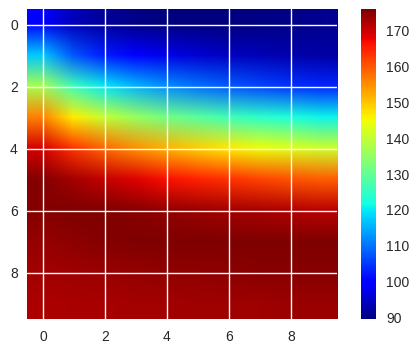

In [291]:
print("Best lambda2 {:2.3f}, sigma2 {:2.3f}".format(lambda2, sigma2))
plt.imshow(np.sqrt(mse), cmap='jet'); plt.colorbar()

In [294]:
Q = np.array([[lambda2, 0], [0, 0]])
R = sigma2
# ---------------------------------------- #

ys = df.values.ravel()
Ns = len(ys)
# ------------ Kalman Filtering ---------- #
kf = KalmanFilter(transition_matrices=F,
                  observation_matrices=H,
                  transition_covariance=Q,
                  observation_covariance=R,
                  initial_state_mean=None,
                  initial_state_covariance=None)

burn_in = 300

_Xold, _Pold = kf.em(ys,em_vars=('transition_matrices','transition_covariance')).filter(ys[:burn_in])
Xold = _Xold[-1]
Pold = _Pold[-1]

y = np.zeros(Ns - burn_in) # filtered output
for t in np.arange(burn_in, Ns):
    Xnew, Pnew = kf.filter_update(filtered_state_mean=Xold,
                                  filtered_state_covariance=Pold,
                                  observation=ys[t])
    Pold = np.array(Pnew)
    Xold = np.array(Xnew)
    y[t - burn_in] = np.dot(Xnew, H)
# ---------------------------------------- #

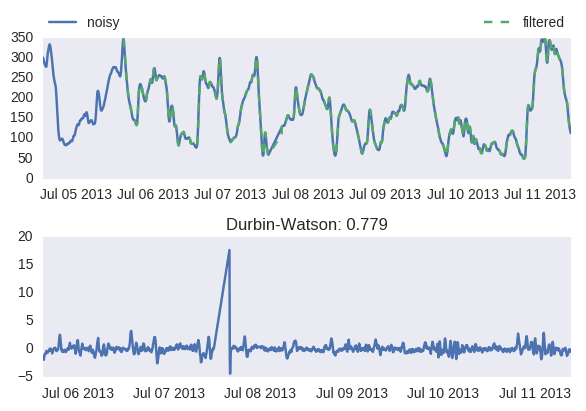

In [295]:
# ---------- Plot ------------------------ #
plt.subplot(211)
plt.plot(ts, ys, '-', label='noisy') # noisy measures
plt.plot(ts[burn_in:], y, '--', label='filtered') # filtered measures
plt.grid()
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)
plt.subplot(212)
residuals = ys.ravel()[burn_in:Ns] - y.ravel()
plt.plot(ts[burn_in:], residuals)
plt.title('Durbin-Watson: {:.3f}'.format(sm.stats.durbin_watson(residuals)));
plt.tight_layout()
plt.grid()

In [166]:
# ------------ Load .mat file ------------ #
data = sio.loadmat('cgm_sample2.mat')
# P0 = data['P0'] # covariance matrix init
ts = data['ts'] # time axis
# X0 = data['X0'] # state at time 0
ys = data['ys'] # CGM values
# ---------------------------------------- #

# ys = ys[:10,:]
# ts = ts[:10,:]

# ------------ Init handy values --------- #
Ns = len(ts) # number of samples
# Pold = np.array(P0) # cov matrix init
# Xold = np.array(X0) # state init
# y(t) = u(t) + v(t)
lamb2 = np.array([1, 0.01, 0.0001]) # values for q00 (variance of u(t))

F = np.array([[2, -1], [1, 0]]) # transition matrix
H = np.array([1, 0]) # measures matrix
Q = np.array([[lamb2[1], 0], [0, 0]])
R = 9
# ---------------------------------------- #

# ------------ Kalman Filtering ---------- #
kf = KalmanFilter(transition_matrices=F,
                  observation_matrices=H,
                  transition_covariance=Q,
                  observation_covariance=R,
                  initial_state_mean=None,
                  initial_state_covariance=None)

burn_in = 300

_Xold, _Pold = kf.em(ys,em_vars=('transition_matrices','transition_covariance')).filter(ys[:300])
Xold = _Xold[-1]
Pold = _Pold[-1]

y = np.zeros(Ns - burn_in) # filtered output
for t in np.arange(burn_in, Ns):
    Xnew, Pnew = kf.filter_update(filtered_state_mean=Xold,
                                  filtered_state_covariance=Pold,
                                  observation=ys[t])
    Pold = np.array(Pnew)
    Xold = np.array(Xnew)
    y[t - burn_in] = np.dot(Xnew, H)
# ---------------------------------------- #

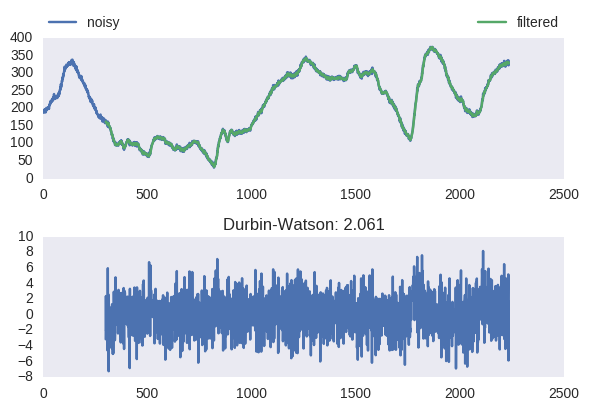

In [170]:
# ---------- Plot ------------------------ #
plt.subplot(211)
plt.plot(ts, ys, label='noisy') # noisy measures
plt.plot(ts[burn_in:Ns], y, label='filtered') # filtered measures
plt.grid()
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)
plt.subplot(212)
residuals = ys.ravel()[burn_in:Ns] - y.ravel()
plt.plot(ts[burn_in:Ns], residuals)
plt.title('Durbin-Watson: {:.3f}'.format(sm.stats.durbin_watson(residuals)))
plt.grid()
plt.tight_layout()
plt.show()
# ---------------------------------------- #

In [296]:
pwd

'/home/samu/.local/share/Trash/files/notebooks'